This code is modified from tensorflow tutorial: https://www.tensorflow.org/tutorials/images/transfer_learning

# Import Libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import mlflow

# Create Train, Validation, and Test Sets

In [0]:
# Set random seed
tf.keras.utils.set_random_seed(42)

In [0]:
# Define paths
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# Load train and validation sets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

# Set a portion of the validation set aside for the test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.

# Optimize Image Loading

In [0]:
# Use buffered prefetching to load images from disk - https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Augment Data

In [0]:
# Increase generalizability of model adding flipped and rotates images to the dataset
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

# Grid Search with MLflow Manual Logging

In [0]:
# Define function to plot model loss for MLflow run
def view_model_loss(history):
    plt.clf()
    plt.plot(history.history["loss"], label="train_loss")
    if "val_loss" in history.history:
        plt.plot(history.history["val_loss"], label="val_loss")
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    return plt

Epoch 1/2
 1/63 [..............................] - ETA: 2:41 - loss: 0.7140 - accuracy: 0.5625 2/63 [..............................] - ETA: 5s - loss: 0.8010 - accuracy: 0.4844  3/63 [>.............................] - ETA: 5s - loss: 0.8264 - accuracy: 0.4896 4/63 [>.............................] - ETA: 5s - loss: 0.7764 - accuracy: 0.4922 5/63 [=>............................] - ETA: 5s - loss: 0.7765 - accuracy: 0.5000 6/63 [=>............................] - ETA: 5s - loss: 0.7336 - accuracy: 0.5417 7/63 [==>...........................] - ETA: 5s - loss: 0.7286 - accuracy: 0.5625 8/63 [==>...........................] - ETA: 5s - loss: 0.7116 - accuracy: 0.5820 9/63 [===>..........................] - ETA: 5s - loss: 0.6951 - accuracy: 0.576410/63 [===>..........................] - ETA: 4s - loss: 0.6869 - accuracy: 0.587511/63 [====>.........................] - ETA: 4s - loss: 0.6673 - accuracy: 0.599412/63 [====>.........................] - ETA: 4s - loss: 0.6520 - accuracy: 0.604213/63 [=====>........................] - ETA: 4s - loss: 0.6418 - accuracy: 0.613014/63 [=====>........................] - ETA: 5s - loss: 0.6279 - accuracy: 0.627215/63 [======>.......................] - ETA: 5s - loss: 0.6170 - accuracy: 0.637516/63 [======>.......................] - ETA: 6s - loss: 0.6147 - accuracy: 0.644517/63 [=======>......................] - ETA: 6s - loss: 0.5921 - accuracy: 0.661818/63 [=======>......................] - ETA: 6s - loss: 0.5855 - accuracy: 0.661519/63 [========>.....................] - ETA: 5s - loss: 0.5729 - accuracy: 0.667820/63 [========>.....................] - ETA: 5s - loss: 0.5608 - accuracy: 0.676621/63 [=========>....................] - ETA: 5s - loss: 0.5529 - accuracy: 0.683022/63 [=========>....................] - ETA: 5s - loss: 0.5468 - accuracy: 0.688923/63 [=========>....................] - ETA: 5s - loss: 0.5405 - accuracy: 0.695724/63 [==========>...................] - ETA: 5s - loss: 0.5373 - accuracy: 0.697925/63 [==========>......

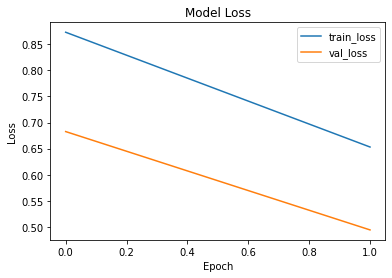

In [0]:
# Define MLflow parent run 
with mlflow.start_run(run_name="Parent Run") as parent_run:
    
    # Define hyperparameter grids
    learning_rates = [0.001, 0.0001]
    beta_1s = [0.5, 0.9]
    
    # Loop over learning rate values
    for lr in learning_rates:
        
        # Loop over beta_1 values
        for beta_1 in beta_1s:
            
            # Start MLflow run
            with mlflow.start_run(nested=True) as run:
                
                # Define model
                IMG_SHAPE = IMG_SIZE + (3,)
                base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
                base_model.trainable = False
                global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
                prediction_layer = tf.keras.layers.Dense(1)
                preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
                rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
                inputs = tf.keras.Input(shape=(160, 160, 3))
                x = data_augmentation(inputs)
                x = preprocess_input(x)
                x = base_model(x, training=False)
                x = global_average_layer(x)
                x = tf.keras.layers.Dropout(0.2)(x)
                outputs = prediction_layer(x)
                model = tf.keras.Model(inputs, outputs)
                
                # Compile model with learning rate and beta_1 value
                model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta_1),
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics=['accuracy'])
                
                # Train model
                history = model.fit(train_dataset,
                            epochs=2,
                            validation_data=validation_dataset)

                
                
                # Create loss plot
                plt = view_model_loss(history)
                fig = plt.gcf()
                
                # Manually log to MLflow model, learning rate, beta_1, val_accuracy, and the loss curve plot
                mlflow.keras.log_model(model, "model")
                mlflow.log_params({"learning_rate": lr, "beta_1":beta_1})
                mlflow.log_metric("val_accuracy", history.history["val_accuracy"][-1])
                mlflow.log_figure(fig, "loss_curve.png")

# Get Best Model Run

In [0]:
# Create MLflow tracking client
from mlflow.tracking import MlflowClient

client = MlflowClient()

In [0]:
# Display all runs
display(client.list_run_infos(run.info.experiment_id))

_artifact_uri,_end_time,_experiment_id,_lifecycle_stage,_run_id,_run_uuid,_start_time,_status,_user_id
dbfs:/databricks/mlflow-tracking/3326441803983792/70629f252f9349f683780dfcefac0208/artifacts,1658608687317,3326441803983792,active,70629f252f9349f683780dfcefac0208,70629f252f9349f683780dfcefac0208,1658608635839,FINISHED,
dbfs:/databricks/mlflow-tracking/3326441803983792/42fb602700cf4a388f004b17b7988354/artifacts,1658608635749,3326441803983792,active,42fb602700cf4a388f004b17b7988354,42fb602700cf4a388f004b17b7988354,1658608586212,FINISHED,
dbfs:/databricks/mlflow-tracking/3326441803983792/eb336c9c5cbf4610988d0775f1227b5e/artifacts,1658608586073,3326441803983792,active,eb336c9c5cbf4610988d0775f1227b5e,eb336c9c5cbf4610988d0775f1227b5e,1658608536791,FINISHED,
dbfs:/databricks/mlflow-tracking/3326441803983792/2ec3e59849544910afca482392398b6f/artifacts,1658608535956,3326441803983792,active,2ec3e59849544910afca482392398b6f,2ec3e59849544910afca482392398b6f,1658608483462,FINISHED,
dbfs:/databricks/mlflow-tracking/3326441803983792/1d294a8b7c19435685b32d3ba3f6661d/artifacts,1658608687433,3326441803983792,active,1d294a8b7c19435685b32d3ba3f6661d,1d294a8b7c19435685b32d3ba3f6661d,1658608483143,FINISHED,
dbfs:/databricks/mlflow-tracking/3326441803983792/38b1133dfdbd429bbb2e20c4ac88771b/artifacts,1658608302621,3326441803983792,active,38b1133dfdbd429bbb2e20c4ac88771b,38b1133dfdbd429bbb2e20c4ac88771b,1658608259222,FINISHED,
dbfs:/databricks/mlflow-tracking/3326441803983792/941c0a9d9ef14d87bfc1fc7b9e66be25/artifacts,1658608259121,3326441803983792,active,941c0a9d9ef14d87bfc1fc7b9e66be25,941c0a9d9ef14d87bfc1fc7b9e66be25,1658608094576,FINISHED,
dbfs:/databricks/mlflow-tracking/3326441803983792/9e3fdd313d224757992c8e9e27ef2101/artifacts,1658608094142,3326441803983792,active,9e3fdd313d224757992c8e9e27ef2101,9e3fdd313d224757992c8e9e27ef2101,1658608049650,FINISHED,
dbfs:/databricks/mlflow-tracking/3326441803983792/6aee26e447a243918b3b9629e6d4712a/artifacts,1658608049521,3326441803983792,active,6aee26e447a243918b3b9629e6d4712a,6aee26e447a243918b3b9629e6d4712a,1658607999523,FINISHED,
dbfs:/databricks/mlflow-tracking/3326441803983792/c8f4805390a84b62bbf97ba20038f279/artifacts,1658608302771,3326441803983792,active,c8f4805390a84b62bbf97ba20038f279,c8f4805390a84b62bbf97ba20038f279,1658607999180,FINISHED,


In [0]:
# Search for run with highest validation accuracy
best_run = client.search_runs(run.info.experiment_id, order_by=["metrics.val_accuracy desc"], max_results=1)
best_run

Out[10]: [<Run: data=<RunData: metrics={'val_accuracy': 0.9740098714828491}, params={'beta_1': '0.9', 'learning_rate': '0.001'}, tags={'mlflow.databricks.cluster.id': '0718-151231-8x9sznuq',
 'mlflow.databricks.cluster.info': '{"cluster_name":"feifei10.4ML","spark_version":"10.4.x-cpu-ml-scala2.12","node_type_id":"i3en.24xlarge","driver_node_type_id":"i3en.24xlarge","autotermination_minutes":120,"disk_spec":{"disk_count":0},"autoscale":{"min_workers":2,"max_workers":8,"target_workers":2}}',
 'mlflow.databricks.cluster.libraries': '{"installable":[],"redacted":[]}',
 'mlflow.databricks.notebook.commandID': '5177803036609176095_6762222272217546740_5893c99599ca40cf9bb14d08401e7661',
 'mlflow.databricks.notebookID': '3326441803983792',
 'mlflow.databricks.notebookPath': '/Users/feifei.wang@databricks.com/20220726_fourthbrain_demo/Transfer '
 'Learning Demo Part 2',
 'mlflow.databricks.notebookRevisionID': '1658608586259',
 'mlflow.databricks.webappURL': 'https://oregon.cloud.databricks.com',
 'mlflow.databricks.workspaceID': '2524178410398960',
 'mlflow.databricks.workspaceURL': 'db-sme-demo-ml-practice.cloud.databricks.com',
 'mlflow.log-model.history': '[{"artifact_path":"model","flavors":{"keras":{"keras_module":"tensorflow.keras","keras_version":"2.8.0","save_format":"tf","data":"data"},"python_function":{"loader_module":"mlflow.keras","python_version":"3.8.10","data":"data","env":"conda.yaml"}},"run_id":"eb336c9c5cbf4610988d0775f1227b5e","model_uuid":"fb745570af3d408096ddc7c303d632a3","utc_time_created":"2022-07-23 '
 '20:36:00.372643","databricks_runtime":"10.4.x-cpu-ml-scala2.12"}]',
 'mlflow.parentRunId': '1d294a8b7c19435685b32d3ba3f6661d',
 'mlflow.rootRunId': '1d294a8b7c19435685b32d3ba3f6661d',
 'mlflow.source.name': '/Users/feifei.wang@databricks.com/20220726_fourthbrain_demo/Transfer '
 'Learning Demo Part 2',
 'mlflow.source.type': 'NOTEBOOK',
 'mlflow.user': 'feifei.wang@databricks.com'}>, info=<RunInfo: artifact_uri='dbfs:/databricks/mlflow-tracking/3326441803983792/eb336c9c5cbf4610988d0775f1227b5e/artifacts', end_time=1658608586073, experiment_id='3326441803983792', lifecycle_stage='active', run_id='eb336c9c5cbf4610988d0775f1227b5e', run_uuid='eb336c9c5cbf4610988d0775f1227b5e', start_time=1658608536791, status='FINISHED', user_id=''>>]

In [0]:
# Alternatively, get past runs as a Spark DataFrame and then query that instead
runs = spark.read.format("mlflow-experiment").load()
display(runs.orderBy("metrics.val_accuracy",ascending=False))

run_id,experiment_id,metrics,params,tags,start_time,end_time,status,artifact_uri
eb336c9c5cbf4610988d0775f1227b5e,3326441803983792,Map(val_accuracy -> 0.9740098714828491),"Map(beta_1 -> 0.9, learning_rate -> 0.001)","Map(mlflow.log-model.history -> [{""artifact_path"":""model"",""flavors"":{""keras"":{""keras_module"":""tensorflow.keras"",""keras_version"":""2.8.0"",""save_format"":""tf"",""data"":""data""},""python_function"":{""loader_module"":""mlflow.keras"",""python_version"":""3.8.10"",""data"":""data"",""env"":""conda.yaml""}},""run_id"":""eb336c9c5cbf4610988d0775f1227b5e"",""model_uuid"":""fb745570af3d408096ddc7c303d632a3"",""utc_time_created"":""2022-07-23 20:36:00.372643"",""databricks_runtime"":""10.4.x-cpu-ml-scala2.12""}], mlflow.parentRunId -> 1d294a8b7c19435685b32d3ba3f6661d, mlflow.databricks.cluster.libraries -> {""installable"":[],""redacted"":[]}, mlflow.databricks.notebook.commandID -> 5177803036609176095_6762222272217546740_5893c99599ca40cf9bb14d08401e7661, mlflow.rootRunId -> 1d294a8b7c19435685b32d3ba3f6661d, mlflow.databricks.notebookPath -> /Users/feifei.wang@databricks.com/20220726_fourthbrain_demo/Transfer Learning Demo Part 2, mlflow.databricks.notebookID -> 3326441803983792, mlflow.databricks.notebookRevisionID -> 1658608586259, mlflow.databricks.cluster.id -> 0718-151231-8x9sznuq, mlflow.source.type -> NOTEBOOK, mlflow.databricks.cluster.info -> {""cluster_name"":""feifei10.4ML"",""spark_version"":""10.4.x-cpu-ml-scala2.12"",""node_type_id"":""i3en.24xlarge"",""driver_node_type_id"":""i3en.24xlarge"",""autotermination_minutes"":120,""disk_spec"":{""disk_count"":0},""autoscale"":{""min_workers"":2,""max_workers"":8,""target_workers"":2}}, mlflow.source.name -> /Users/feifei.wang@databricks.com/20220726_fourthbrain_demo/Transfer Learning Demo Part 2, mlflow.user -> feifei.wang@databricks.com, mlflow.databricks.workspaceURL -> db-sme-demo-ml-practice.cloud.databricks.com, mlflow.databricks.workspaceID -> 2524178410398960, mlflow.databricks.webappURL -> https://oregon.cloud.databricks.com)",2022-07-23T20:35:36.791+0000,2022-07-23T20:36:26.073+0000,FINISHED,dbfs:/databricks/mlflow-tracking/3326441803983792/eb336c9c5cbf4610988d0775f1227b5e/artifacts
9e3fdd313d224757992c8e9e27ef2101,3326441803983792,Map(val_accuracy -> 0.9740098714828491),"Map(beta_1 -> 0.9, learning_rate -> 0.001)","Map(mlflow.log-model.history -> [{""artifact_path"":""model"",""flavors"":{""keras"":{""keras_module"":""tensorflow.keras"",""keras_version"":""2.8.0"",""save_format"":""tf"",""data"":""data""},""python_function"":{""loader_module"":""mlflow.keras"",""python_version"":""3.8.10"",""data"":""data"",""env"":""conda.yaml""}},""run_id"":""9e3fdd313d224757992c8e9e27ef2101"",""model_uuid"":""c313074551a24e9385dcf738de7a86a5"",""utc_time_created"":""2022-07-23 20:27:47.280147"",""databricks_runtime"":""10.4.x-cpu-ml-scala2.12""}], mlflow.parentRunId -> c8f4805390a84b62bbf97ba20038f279, mlflow.databricks.cluster.libraries -> {""installable"":[],""redacted"":[]}, mlflow.databricks.notebook.commandID -> 2707775683539094238_7151567238128770774_577e5e8438c74da08863c25388553b77, mlflow.rootRunId -> c8f4805390a84b62bbf97ba20038f279, mlflow.databricks.notebookPath -> /Users/feifei.wang@databricks.com/20220726_fourthbrain_demo/Transfer Learning Demo Part 2, mlflow.databricks.notebookID -> 3326441803983792, mlflow.databricks.notebookRevisionID -> 1658608094613, mlflow.databricks.cluster.id -> 0718-151231-8x9sznuq, mlflow.source.type -> NOTEBOOK, mlflow.databricks.cluster.info -> {""cluster_name"":""feifei10.4ML"",""spark_version"":""10.4.x-cpu-ml-scala2.12"",""node_type_id"":""i3en.24xlarge"",""driver_node_type_id"":""i3en.24xlarge"",""autotermination_minutes"":120,""disk_spec"":{""disk_count"":0},""autoscale"":{""min_workers"":2,""max_workers"":8,""target_workers"":2}}, mlflow.source.name -> /Users/feifei.wang@databricks.com/20220726_fourthbrain_demo/Transfer Learning Demo Part 2, mlflow.user -> feifei.wang@databricks.com, mlflow.databricks.w

In [0]:
best_run_id = runs.orderBy("metrics.val_accuracy",ascending=False).first()["run_id"]
best_run_id

Out[12]: 'eb336c9c5cbf4610988d0775f1227b5e'

# Register Best Model (Below are optional)
Note: model registry is currently not available on the free Databricks Community Edition, but is available on Databricks enterprise editions. If you would like to run code locally, you may need to config additional settings.

In [0]:
# # Register the best model to MLflow model registry
# model_uri = f"runs:/{best_run_id}/model"

# model_details = mlflow.register_model(model_uri=model_uri, name="demo_transfer_learning")

Registered model 'demo_transfer_learning' already exists. Creating a new version of this model...
2022/07/23 20:38:09 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: demo_transfer_learning, version 2
Created version '2' of model 'demo_transfer_learning'.

# Load Model From Registry

In [0]:
# # Load in first version of model
# model_path = f"models:/demo_transfer_learning/1" 
# print(f"Loading registered model version from URI: '{model_path}'")

# # Load model
# loaded_model = mlflow.keras.load_model(model_path)

Loading registered model version from URI: 'models:/demo_transfer_learning/1'

Dog!

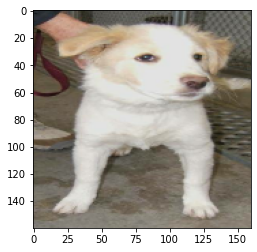

In [0]:
# # Display image to predict
# image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# image_to_predict = image_batch[1]
# plt.imshow(image_to_predict.astype("uint8"))

# # Predict, values closer to 0 are cats, closer to 1 are dogs
# def cat_or_dog(im):
#     if tf.nn.sigmoid(loaded_model.predict(np.expand_dims(im, axis=0))).numpy()[0][0] < 0.5:
#         print("Cat!")
#     else:
#         print("Dog!")
# cat_or_dog(image_to_predict)